# Modul 1.2 Klimasystemet - Toboksmodellen
<img src="Bilder/2D_model_schematic.png">

I denne øvelsen ska vi gi en innføring i 2boksmodellen og hvordan vi ka bruke den til å beregne ændringer i jordens temperatur over tid. Toboksmodellen er en forenklet klimamodell. Den ser på hvordan energibalancen på jorden endrer seg utfra endringer i de ulike strålingspådrivene. I figuren over ser dere at man ser på en balanse mellom stråling som går inn og ut på toppen av atmosfæren (TOA), samt de energiovergangene vi har på grensen mellom atmosfæren og det øverste laget i havet, samt at det går noe varme fra havets blandingslag til dyphavet. 

De som ønsker å forstå hvordan man kommer frem til formlene for beregning av temperaturendring som følge av endringer i strålingspådrivet anbefales å lese kompendiet *Climate Sensitivity*. Der vises det hvordan vi kommer frem til likningene under. Disse likningene er kodet og ligger i en Python-fil i mappen deres. Filen heter toboks.py.

$c_{mix}$ og $c_{deep}$ forteller om varmekapasiteten til overflatelaget i havet og i dyphavet. $\Delta T_s$ gir endringer i overflatetemperaturer, mens $\Delta T_o$ endringer i temperaturen i dyphavet. $\lambda$ er tilbakekoblingseffekter (*climate feedbaks*), og $\gamma$ varmeopptak i havet.

$$\begin{align}
c_{mix}\dfrac{d\Delta T_s}{dt}&=\Delta Q-\lambda \Delta T_s -\gamma (\Delta T_s -\Delta T_0)     \qquad   (\mathit{1}) \\
c_{deep}\dfrac{d\Delta T_o}{dt}&=\gamma (\Delta T_s - \Delta T_o)  \qquad   (\mathit{2}) 
\end{align}$$


In [1]:
# Lese inn relavente python pakker vi ska bruke
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline inkluder denne linjen om du vil åpne i Jupyter Notebook og vil lage interaktive plott

from toboks import calculate_temp_anomalies # henter funksjonen som beregner temperaturanomalier basert på toboksmodellen


## Sette op ToBoksModellen
For at sette opp modellen, må vi først hente inn data for de ulike strålingspådriv og beregne det totale pådriv ($\Delta$Q). Dernæst må vi bestemme hvilke ulike tilbagekoblingsfaktorer ($\gamma$) som modellen ska ta med. Dette bruker 2boksmodellen som "input" for å lage beregninger.

### 1. Bestem strålingspådrivene

I denne øvelsen tar vi utgangspunkt i historisk data for perioden 1750-2011 som er basert på observationer. Her ser vi på følgene strålingspådriv:

- drivhusgasser 
- solinnstråling
- vulkanisme
- arealbruk 
- aerosoler (menneskeskapte)

Det totale strålingspådriv ($\Delta$Q) er givet ved:

$$\begin{align}
\Delta Q=\Delta Q_{drivhus} + \Delta Q_{sol} + \Delta Q_{vulkan} + \Delta Q_{arealbruk} + \Delta Q_{aerosoler} 
\end{align}$$


In [2]:
# les inn historisk data fra filen 'historical.csv'
df=pd.read_csv('historical.csv',index_col = 0,sep=',',encoding = "utf-8")

Noen ganger så ønsker man bare å studere effektene av eksempelvis solens aktivitet. Sett parameterne under til 1 eller 0, alt ettersom du ønsker å ha dem med eller ei. I koden under lages en ny dataramme som inneholder totalt pådriv med disse faktorene.

In [3]:
# --------------------
# Forcing switches [n=1 off=0]
# --------------------
switch_ghg=1     # Greenhouse gas forcing on=1 off=0
switch_solar=1   # Solar forcing on=1 off=0
switch_volc=1    # Volcanic forcing on=1 off=0
switch_land=1    # Landuse forcing on=1 off=0
switch_aero=1    # Pollution particle forcing on=1 off=0

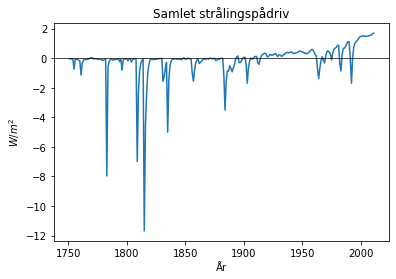

In [4]:
# Beregn og plot det totale strålingspådriv
total_forcing = switch_ghg*df['drivhusgasser']+switch_solar*df['solinnstråling']+switch_volc*df['vulkanisme']+switch_land*df['arealbruk']+switch_aero*df['aerosoler']
total_forcing.plot(title="Samlet strålingspådriv",ylabel="$W/m^2$")
plt.axhline(y=0, linewidth=0.7, color="black")

### 2. Bestem tilbakekoblingsfaktorer (climate feedbacks)

Værdiene for de ulike tilbakekoblingsfaktorer er hentet fra *Soden and Held (2006)* og er basert på output fra 14 ulike klimamodeller som bidrar til IPCC rapporten. 

<img src="Bilder/table_lambda_values.png">


In [5]:
# CMIP5 values
lambda_planck=-3.21     # Stefan Boltzmann's 'feedback' [Wm-2K-1] best guesses  [-3.3 to -3.1]
lambda_lapse=-0.84      # Lapse rate feedback [Wm-2K-1] best guesses [-1.2 to -0.5]
lambda_water=1.8       # water vapor feedback [Wm-2K-1] best guesses [1.5 to 2.2]
lambda_cloud=0.69      # Clouds feedback [Wm-2K-1] best guesses [0.1 to 1.2]
lambda_albedo=0.26     # Surface albedo feedback [Wm-2K-1] best guesses [0.1 to 0.4]
lambda_other=0.0       # Other feedbacks [Wm-2K-1]

lambda_sum=sum([lambda_planck,
    lambda_lapse,
    lambda_water,
    lambda_cloud,
    lambda_albedo,
    lambda_other])

In [6]:
# Deep ocean heat uptake efficency [Wm-2K-1] fra Dufresne and Bony (2008).
gamma=-0.69  # best guesses [-1 to -0.5]

In [7]:
radiative_forcing = total_forcing.to_numpy() # konverter dataframe til data-array

## Temperaturendringer for perioden 1750-2011
Vi ønsker nå å beregne hvordan temperaturen endrer seg som resultat av hvilke strålingspådriv vi har slått på, verdiene vi har satt for tilbakekoblingsmekanismer, og varmeutveksling til havet. 

In [8]:
Ts, To = calculate_temp_anomalies(radiative_forcing, lambda_sum, gamma) # kaller opp funksjonen som regner ut temperaturendringene

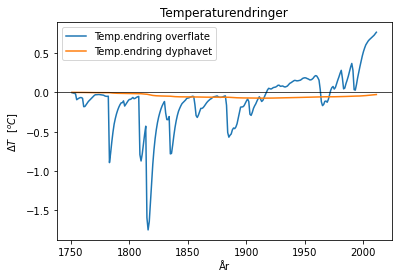

In [9]:
temp = pd.DataFrame(index=df.index) # vi lager en ny dataramme som har samme indexer (i.e. årstal) som pådrivet
temp['Temp.endring overflate']=Ts
temp['Temp.endring dyphavet']=To
temp.plot(ylabel="$\Delta T$  $[^oC]$", title="Temperaturendringer")
plt.axhline(y=0, linewidth=0.7, color="black")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5fb09802e0>,
      dtype=object)

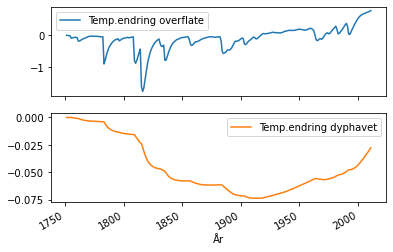

In [10]:
# samme plot men i hver sin figur
temp.plot(subplots=True)

## Øvelser

Nu har dere fået et innblikk i hvordan modellen fungerer. Bruk hva dere har lært til at undersøke følgene:
    
1. Beregn og plot endringen i overflatetemperatur (*Ts*) relativt til perioden 1850-1900 (*pre-industrial period*)
    - TIPS
        - prøv å lage en ny variabel som bare inneholder *Ts* for perioden 1850-1900 (e.g. "Ts1850_1900"). Se notebook fra Modul0 for hjelp. 
        - beregn nu middelstemp. for denne periode (bruk funktionen .mean()). NB. alt ka gjøres i én enkel linje. 
        
        
2. Hvor mye har overflatetemperaturen (*Ts*) i år 2011 endret sig i forhold til perioden 1850-1900? 

3. Hva er den primære årsakken til denne endringen? Finn en måte å illustrere dette på.

4. Forklar med dine egen ord betydingen av hvert led i ligning (1). Undersøk deretter med modellen ved å slå av/på henholdsvis tilbakekoblingsmek. ($\lambda$) og varmeutveklsingen ($\gamma$)

    - Hvordan påvirkes overflatetemperaturen av disse endringene?



### BONUS: Finn selv på noe å undersøke med modellen
Presenter efterfølgende for resten af gruppen